In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stopwords/Greek-Stopwords (1).txt
/kaggle/input/ys19-2023-assignment-2/sample_submission.csv
/kaggle/input/ys19-2023-assignment-2/test_set.csv
/kaggle/input/ys19-2023-assignment-2/valid_set.csv
/kaggle/input/ys19-2023-assignment-2/train_set.csv
/kaggle/input/w2v-200-model/w2v200_sg.model


In [2]:
!pip install demoji optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 3.2 MB/s eta 0:00:00


In [3]:
import re # for regular expressions
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk # for text manipulation
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from tqdm import tqdm
%matplotlib inline
import demoji
import gensim
from gensim.models import Word2Vec
import random
import shutil
import optuna
from optuna.trial import TrialState
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch.utils.data import TensorDataset, DataLoader
import torch.optim.lr_scheduler as lr_scheduler

from sklearn import metrics
from sklearn.model_selection import learning_curve
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler
from numpy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc, classification_report

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Greek Stemming code from : https://gist.github.com/Patelis-GM/e1f8cf553f27ff40ed49db8c310611b3

In [4]:
__cases = dict()
__cases["ΦΑΓΙΑ"] = "ΦΑ"
__cases["ΦΑΓΙΟΥ"] = "ΦΑ"
__cases["ΦΑΓΙΩΝ"] = "ΦΑ"
__cases["ΣΚΑΓΙΑ"] = "ΣΚΑ"
__cases["ΣΚΑΓΙΟΥ"] = "ΣΚΑ"
__cases["ΣΚΑΓΙΩΝ"] = "ΣΚΑ"
__cases["ΟΛΟΓΙΟΥ"] = "ΟΛΟ"
__cases["ΟΛΟΓΙΑ"] = "ΟΛΟ"
__cases["ΟΛΟΓΙΩΝ"] = "ΟΛΟ"
__cases["ΣΟΓΙΟΥ"] = "ΣΟ"
__cases["ΣΟΓΙΑ"] = "ΣΟ"
__cases["ΣΟΓΙΩΝ"] = "ΣΟ"
__cases["ΤΑΤΟΓΙΑ"] = "ΤΑΤΟ"
__cases["ΤΑΤΟΓΙΟΥ"] = "ΤΑΤΟ"
__cases["ΤΑΤΟΓΙΩΝ"] = "ΤΑΤΟ"
__cases["ΚΡΕΑΣ"] = "ΚΡΕ"
__cases["ΚΡΕΑΤΟΣ"] = "ΚΡΕ"
__cases["ΚΡΕΑΤΑ"] = "ΚΡΕ"
__cases["ΚΡΕΑΤΩΝ"] = "ΚΡΕ"
__cases["ΠΕΡΑΣ"] = "ΠΕΡ"
__cases["ΠΕΡΑΤΟΣ"] = "ΠΕΡ"
__cases["ΠΕΡΑΤΑ"] = "ΠΕΡ"
__cases["ΠΕΡΑΤΩΝ"] = "ΠΕΡ"
__cases["ΤΕΡΑΣ"] = "ΤΕΡ"
__cases["ΤΕΡΑΤΟΣ"] = "ΤΕΡ"
__cases["ΤΕΡΑΤΑ"] = "ΤΕΡ"
__cases["ΤΕΡΑΤΩΝ"] = "ΤΕΡ"
__cases["ΦΩΣ"] = "ΦΩ"
__cases["ΦΩΤΟΣ"] = "ΦΩ"
__cases["ΦΩΤΑ"] = "ΦΩ"
__cases["ΦΩΤΩΝ"] = "ΦΩ"
__cases["ΚΑΘΕΣΤΩΣ"] = "ΚΑΘΕΣΤ"
__cases["ΚΑΘΕΣΤΩΤΟΣ"] = "ΚΑΘΕΣΤ"
__cases["ΚΑΘΕΣΤΩΤΑ"] = "ΚΑΘΕΣΤ"
__cases["ΚΑΘΕΣΤΩΤΩΝ"] = "ΚΑΘΕΣΤ"
__cases["ΓΕΓΟΝΟΣ"] = "ΓΕΓΟΝ"
__cases["ΓΕΓΟΝΟΤΟΣ"] = "ΓΕΓΟΝ"
__cases["ΓΕΓΟΝΟΤΑ"] = "ΓΕΓΟΝ"
__cases["ΓΕΓΟΝΟΤΩΝ"] = "ΓΕΓΟΝ"
__vowels = "[ΑΕΗΙΟΥΩ]"
__refinedVowels = "[ΑΕΗΙΟΩ]"


def stemWord(w: str, exceptions: dict = None):
    stem = None
    suffix = None
    test1 = True

    if exceptions is not None and w in exceptions.keys():
        return exceptions[w]

    if len(w) < 4:
        return w

    pattern = None
    pattern2 = None
    pattern3 = None
    pattern4 = None

    # Step1
    pattern = re.compile(
        r"(.*)(ΦΑΓΙΑ|ΦΑΓΙΟΥ|ΦΑΓΙΩΝ|ΣΚΑΓΙΑ|ΣΚΑΓΙΟΥ|ΣΚΑΓΙΩΝ|ΟΛΟΓΙΟΥ|ΟΛΟΓΙΑ|ΟΛΟΓΙΩΝ|ΣΟΓΙΟΥ|ΣΟΓΙΑ|ΣΟΓΙΩΝ|ΤΑΤΟΓΙΑ|ΤΑΤΟΓΙΟΥ|ΤΑΤΟΓΙΩΝ|ΚΡΕΑΣ|ΚΡΕΑΤΟΣ|ΚΡΕΑΤΑ|ΚΡΕΑΤΩΝ|ΠΕΡΑΣ|ΠΕΡΑΤΟΣ|ΠΕΡΑΤΑ|ΠΕΡΑΤΩΝ|ΤΕΡΑΣ|ΤΕΡΑΤΟΣ|ΤΕΡΑΤΑ|ΤΕΡΑΤΩΝ|ΦΩΣ|ΦΩΤΟΣ|ΦΩΤΑ|ΦΩΤΩΝ|ΚΑΘΕΣΤΩΣ|ΚΑΘΕΣΤΩΤΟΣ|ΚΑΘΕΣΤΩΤΑ|ΚΑΘΕΣΤΩΤΩΝ|ΓΕΓΟΝΟΣ|ΓΕΓΟΝΟΤΟΣ|ΓΕΓΟΝΟΤΑ|ΓΕΓΟΝΟΤΩΝ)$")

    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        suffix = fp[1]
        w = stem + __cases[suffix]
        test1 = False

    # Step 2a
    pattern = re.compile(r"^(.+?)(ΑΔΕΣ|ΑΔΩΝ)$")
    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        reg1 = re.compile(r"(ΟΚ|ΜΑΜ|ΜΑΝ|ΜΠΑΜΠ|ΠΑΤΕΡ|ΓΙΑΓΙ|ΝΤΑΝΤ|ΚΥΡ|ΘΕΙ|ΠΕΘΕΡ)$")

        if not reg1.match(w):
            w = w + "ΑΔ"

    # Step 2b
    pattern2 = re.compile(r"^(.+?)(ΕΔΕΣ|ΕΔΩΝ)$")
    if pattern2.match(w):
        fp = pattern2.match(w).groups()
        stem = fp[0]
        w = stem
        except2 = re.compile(r"(ΟΠ|ΙΠ|ΕΜΠ|ΥΠ|ΓΗΠ|ΔΑΠ|ΚΡΑΣΠ|ΜΙΛ)$")
        if except2.match(w):
            w = w + "ΕΔ"

    # Step 2c
    pattern3 = re.compile(r"^(.+?)(ΟΥΔΕΣ|ΟΥΔΩΝ)$")
    if pattern3.match(w):
        fp = pattern3.match(w).groups()
        stem = fp[0]
        w = stem
        except3 = re.compile(r"(ΑΡΚ|ΚΑΛΙΑΚ|ΠΕΤΑΛ|ΛΙΧ|ΠΛΕΞ|ΣΚ|Σ|ΦΛ|ΦΡ|ΒΕΛ|ΛΟΥΛ|ΧΝ|ΣΠ|ΤΡΑΓ|ΦΕ)$")
        if except3.match(w):
            w = w + "ΟΥΔ"

    # Step 2d
    pattern4 = re.compile("^(.+?)(ΕΩΣ|ΕΩΝ)$")
    if pattern4.match(w):
        fp = pattern4.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        except4 = re.compile(r"^(Θ|Δ|ΕΛ|ΓΑΛ|Ν|Π|ΙΔ|ΠΑΡ)$")
        if except4.match(w):
            w = w + "Ε"

    # Step 3
    pattern = re.compile(r"^(.+?)(ΙΑ|ΙΟΥ|ΙΩΝ)$")
    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        pattern2 = re.compile(__vowels + "$")
        test1 = False
        if pattern2.match(w):
            w = stem + "Ι"

    # Step 4
    pattern = re.compile(r"^(.+?)(ΙΚΑ|ΙΚΟ|ΙΚΟΥ|ΙΚΩΝ)$")
    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        pattern2 = re.compile(__vowels + "$")
        except5 = re.compile(
            r"^(ΑΛ|ΑΔ|ΕΝΔ|ΑΜΑΝ|ΑΜΜΟΧΑΛ|ΗΘ|ΑΝΗΘ|ΑΝΤΙΔ|ΦΥΣ|ΒΡΩΜ|ΓΕΡ|ΕΞΩΔ|ΚΑΛΠ|ΚΑΛΛΙΝ|ΚΑΤΑΔ|ΜΟΥΛ|ΜΠΑΝ|ΜΠΑΓΙΑΤ|ΜΠΟΛ|ΜΠΟΣ|ΝΙΤ|ΞΙΚ|ΣΥΝΟΜΗΛ|ΠΕΤΣ|ΠΙΤΣ|ΠΙΚΑΝΤ|ΠΛΙΑΤΣ|ΠΟΣΤΕΛΝ|ΠΡΩΤΟΔ|ΣΕΡΤ|ΣΥΝΑΔ|ΤΣΑΜ|ΥΠΟΔ|ΦΙΛΟΝ|ΦΥΛΟΔ|ΧΑΣ)$")
        if except5.match(w) or pattern2.match(w):
            w = w + "ΙΚ"

    # step 5a
    pattern = re.compile(r"^(.+?)(ΑΜΕ)$")
    pattern2 = re.compile(r"^(.+?)(ΑΓΑΜΕ|ΗΣΑΜΕ|ΟΥΣΑΜΕ|ΗΚΑΜΕ|ΗΘΗΚΑΜΕ)$")
    if w == "ΑΓΑΜΕ":
        w = "ΑΓΑΜ"

    if pattern2.match(w):
        fp = pattern2.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False

    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        except6 = re.compile(r"^(ΑΝΑΠ|ΑΠΟΘ|ΑΠΟΚ|ΑΠΟΣΤ|ΒΟΥΒ|ΞΕΘ|ΟΥΛ|ΠΕΘ|ΠΙΚΡ|ΠΟΤ|ΣΙΧ|Χ)$")
        if except6.match(w):
            w = w + "ΑΜ"

    # Step 5b
    pattern2 = re.compile(r"^(.+?)(ΑΝΕ)$")
    pattern3 = re.compile(r"^(.+?)(ΑΓΑΝΕ|ΗΣΑΝΕ|ΟΥΣΑΝΕ|ΙΟΝΤΑΝΕ|ΙΟΤΑΝΕ|ΙΟΥΝΤΑΝΕ|ΟΝΤΑΝΕ|ΟΤΑΝΕ|ΟΥΝΤΑΝΕ|ΗΚΑΝΕ|ΗΘΗΚΑΝΕ)$")
    if pattern3.match(w):
        fp = pattern3.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        pattern3 = re.compile(r"^(ΤΡ|ΤΣ)$")
        if pattern3.match(w):
            w = w + "ΑΓΑΝ"

    if pattern2.match(w):
        fp = pattern2.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        pattern2 = re.compile(__refinedVowels + "$")
        except7 = re.compile(
            r"^(ΒΕΤΕΡ|ΒΟΥΛΚ|ΒΡΑΧΜ|Γ|ΔΡΑΔΟΥΜ|Θ|ΚΑΛΠΟΥΖ|ΚΑΣΤΕΛ|ΚΟΡΜΟΡ|ΛΑΟΠΛ|ΜΩΑΜΕΘ|Μ|ΜΟΥΣΟΥΛΜ|Ν|ΟΥΛ|Π|ΠΕΛΕΚ|ΠΛ|ΠΟΛΙΣ|ΠΟΡΤΟΛ|ΣΑΡΑΚΑΤΣ|ΣΟΥΛΤ|ΤΣΑΡΛΑΤ|ΟΡΦ|ΤΣΙΓΓ|ΤΣΟΠ|ΦΩΤΟΣΤΕΦ|Χ|ΨΥΧΟΠΛ|ΑΓ|ΟΡΦ|ΓΑΛ|ΓΕΡ|ΔΕΚ|ΔΙΠΛ|ΑΜΕΡΙΚΑΝ|ΟΥΡ|ΠΙΘ|ΠΟΥΡΙΤ|Σ|ΖΩΝΤ|ΙΚ|ΚΑΣΤ|ΚΟΠ|ΛΙΧ|ΛΟΥΘΗΡ|ΜΑΙΝΤ|ΜΕΛ|ΣΙΓ|ΣΠ|ΣΤΕΓ|ΤΡΑΓ|ΤΣΑΓ|Φ|ΕΡ|ΑΔΑΠ|ΑΘΙΓΓ|ΑΜΗΧ|ΑΝΙΚ|ΑΝΟΡΓ|ΑΠΗΓ|ΑΠΙΘ|ΑΤΣΙΓΓ|ΒΑΣ|ΒΑΣΚ|ΒΑΘΥΓΑΛ|ΒΙΟΜΗΧ|ΒΡΑΧΥΚ|ΔΙΑΤ|ΔΙΑΦ|ΕΝΟΡΓ|ΘΥΣ|ΚΑΠΝΟΒΙΟΜΗΧ|ΚΑΤΑΓΑΛ|ΚΛΙΒ|ΚΟΙΛΑΡΦ|ΛΙΒ|ΜΕΓΛΟΒΙΟΜΗΧ|ΜΙΚΡΟΒΙΟΜΗΧ|ΝΤΑΒ|ΞΗΡΟΚΛΙΒ|ΟΛΙΓΟΔΑΜ|ΟΛΟΓΑΛ|ΠΕΝΤΑΡΦ|ΠΕΡΗΦ|ΠΕΡΙΤΡ|ΠΛΑΤ|ΠΟΛΥΔΑΠ|ΠΟΛΥΜΗΧ|ΣΤΕΦ|ΤΑΒ|ΤΕΤ|ΥΠΕΡΗΦ|ΥΠΟΚΟΠ|ΧΑΜΗΛΟΔΑΠ|ΨΗΛΟΤΑΒ)$")
        if (pattern2.match(w)) or (except7.match(w)):
            w = w + "ΑΝ"

    # //Step 5c
    pattern3 = re.compile(r"^(.+?)(ΕΤΕ)$")
    pattern4 = re.compile(r"^(.+?)(ΗΣΕΤΕ)$")
    if pattern4.match(w):
        fp = pattern4.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False

    if pattern3.match(w):
        fp = pattern3.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        pattern3 = re.compile(__refinedVowels + "$")
        except8 = re.compile(
            r"(ΟΔ|ΑΙΡ|ΦΟΡ|ΤΑΘ|ΔΙΑΘ|ΣΧ|ΕΝΔ|ΕΥΡ|ΤΙΘ|ΥΠΕΡΘ|ΡΑΘ|ΕΝΘ|ΡΟΘ|ΣΘ|ΠΥΡ|ΑΙΝ|ΣΥΝΔ|ΣΥΝ|ΣΥΝΘ|ΧΩΡ|ΠΟΝ|ΒΡ|ΚΑΘ|ΕΥΘ|ΕΚΘ|ΝΕΤ|ΡΟΝ|ΑΡΚ|ΒΑΡ|ΒΟΛ|ΩΦΕΛ)$")
        except9 = re.compile(
            r"^(ΑΒΑΡ|ΒΕΝ|ΕΝΑΡ|ΑΒΡ|ΑΔ|ΑΘ|ΑΝ|ΑΠΛ|ΒΑΡΟΝ|ΝΤΡ|ΣΚ|ΚΟΠ|ΜΠΟΡ|ΝΙΦ|ΠΑΓ|ΠΑΡΑΚΑΛ|ΣΕΡΠ|ΣΚΕΛ|ΣΥΡΦ|ΤΟΚ|Υ|Δ|ΕΜ|ΘΑΡΡ|Θ)$")
        if (pattern3.match(w)) or (except8.match(w)) or (except9.match(w)):
            w = w + "ΕΤ"

    # Step 5d
    pattern = re.compile(r"^(.+?)(ΟΝΤΑΣ|ΩΝΤΑΣ)$")
    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        except10 = re.compile(r"^(ΑΡΧ)$")
        except11 = re.compile(r"(ΚΡΕ)$")
        if except10.match(w):
            w = w + "ΟΝΤ"
        if except11.match(w):
            w = w + "ΩΝΤ"

    # Step 5e
    pattern = re.compile(r"^(.+?)(ΟΜΑΣΤΕ|ΙΟΜΑΣΤΕ)$")
    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        except11 = re.compile("^(ΟΝ)$")
        if except11.match(w):
            w = w + "ΟΜΑΣΤ"

    # Step 5f
    pattern = re.compile(r"^(.+?)(ΕΣΤΕ)$")
    pattern2 = re.compile(r"^(.+?)(ΙΕΣΤΕ)$")
    if pattern2.match(w):
        fp = pattern2.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        pattern2 = re.compile(r"^(Π|ΑΠ|ΣΥΜΠ|ΑΣΥΜΠ|ΑΚΑΤΑΠ|ΑΜΕΤΑΜΦ)$")
        if pattern2.match(w):
            w = w + "ΙΕΣΤ"

    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        except12 = re.compile(r"^(ΑΛ|ΑΡ|ΕΚΤΕΛ|Ζ|Μ|Ξ|ΠΑΡΑΚΑΛ|ΑΡ|ΠΡΟ|ΝΙΣ)$")
        if except12.match(w):
            w = w + "ΕΣΤ"

    # Step 5g
    pattern = re.compile(r"^(.+?)(ΗΚΑ|ΗΚΕΣ|ΗΚΕ)$")
    pattern2 = re.compile(r"^(.+?)(ΗΘΗΚΑ|ΗΘΗΚΕΣ|ΗΘΗΚΕ)$")
    if pattern2.match(w):
        fp = pattern2.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False

    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        except13 = re.compile(r"(ΣΚΩΛ|ΣΚΟΥΛ|ΝΑΡΘ|ΣΦ|ΟΘ|ΠΙΘ)$")
        except14 = re.compile(r"^(ΔΙΑΘ|Θ|ΠΑΡΑΚΑΤΑΘ|ΠΡΟΣΘ|ΣΥΝΘ|)$")
        if (except13.match(w)) or (except14.match(w)):
            w = w + "ΗΚ"

    # Step 5h
    pattern = re.compile(r"^(.+?)(ΟΥΣΑ|ΟΥΣΕΣ|ΟΥΣΕ)$")
    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        except15 = re.compile(
            r"^(ΦΑΡΜΑΚ|ΧΑΔ|ΑΓΚ|ΑΝΑΡΡ|ΒΡΟΜ|ΕΚΛΙΠ|ΛΑΜΠΙΔ|ΛΕΧ|Μ|ΠΑΤ|Ρ|Λ|ΜΕΔ|ΜΕΣΑΖ|ΥΠΟΤΕΙΝ|ΑΜ|ΑΙΘ|ΑΝΗΚ|ΔΕΣΠΟΖ|ΕΝΔΙΑΦΕΡ|ΔΕ|ΔΕΥΤΕΡΕΥ|ΚΑΘΑΡΕΥ|ΠΛΕ|ΤΣΑ)$")
        except16 = re.compile(r"(ΠΟΔΑΡ|ΒΛΕΠ|ΠΑΝΤΑΧ|ΦΡΥΔ|ΜΑΝΤΙΛ|ΜΑΛΛ|ΚΥΜΑΤ|ΛΑΧ|ΛΗΓ|ΦΑΓ|ΟΜ|ΠΡΩΤ)$")
        if (except15.match(w)) or (except16.match(w)):
            w = w + "ΟΥΣ"

    # Step 5i
    pattern = re.compile(r"^(.+?)(ΑΓΑ|ΑΓΕΣ|ΑΓΕ)$")
    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        except17 = re.compile(r"^(ΨΟΦ|ΝΑΥΛΟΧ)$")
        except20 = re.compile(r"(ΚΟΛΛ)$")
        except18 = re.compile(
            r"^(ΑΒΑΣΤ|ΠΟΛΥΦ|ΑΔΗΦ|ΠΑΜΦ|Ρ|ΑΣΠ|ΑΦ|ΑΜΑΛ|ΑΜΑΛΛΙ|ΑΝΥΣΤ|ΑΠΕΡ|ΑΣΠΑΡ|ΑΧΑΡ|ΔΕΡΒΕΝ|ΔΡΟΣΟΠ|ΞΕΦ|ΝΕΟΠ|ΝΟΜΟΤ|ΟΛΟΠ|ΟΜΟΤ|ΠΡΟΣΤ|ΠΡΟΣΩΠΟΠ|ΣΥΜΠ|ΣΥΝΤ|Τ|ΥΠΟΤ|ΧΑΡ|ΑΕΙΠ|ΑΙΜΟΣΤ|ΑΝΥΠ|ΑΠΟΤ|ΑΡΤΙΠ|ΔΙΑΤ|ΕΝ|ΕΠΙΤ|ΚΡΟΚΑΛΟΠ|ΣΙΔΗΡΟΠ|Λ|ΝΑΥ|ΟΥΛΑΜ|ΟΥΡ|Π|ΤΡ|Μ)$")
        except19 = re.compile(r"(ΟΦ|ΠΕΛ|ΧΟΡΤ|ΛΛ|ΣΦ|ΡΠ|ΦΡ|ΠΡ|ΛΟΧ|ΣΜΗΝ)$")
        if (except18.match(w) and except19.match(w)) and not ((except17.match(w)) or (except20.match(w))):
            w = w + "ΑΓ"

    # Step 5j
    pattern = re.compile("^(.+?)(ΗΣΕ|ΗΣΟΥ|ΗΣΑ)$")
    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        except21 = re.compile(r"^(Ν|ΧΕΡΣΟΝ|ΔΩΔΕΚΑΝ|ΕΡΗΜΟΝ|ΜΕΓΑΛΟΝ|ΕΠΤΑΝ)$")
        if except21.match(w):
            w = w + "ΗΣ"

    # Step 5k
    pattern = re.compile(r"^(.+?)(ΗΣΤΕ)$")

    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        except22 = re.compile(r"^(ΑΣΒ|ΣΒ|ΑΧΡ|ΧΡ|ΑΠΛ|ΑΕΙΜΝ|ΔΥΣΧΡ|ΕΥΧΡ|ΚΟΙΝΟΧΡ|ΠΑΛΙΜΨ)$")
        if except22.match(w):
            w = w + "ΗΣΤ"

    # Step 5l
    pattern = re.compile("^(.+?)(ΟΥΝΕ|ΗΣΟΥΝΕ|ΗΘΟΥΝΕ)$")
    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        except23 = re.compile("^(Ν|Ρ|ΣΠΙ|ΣΤΡΑΒΟΜΟΥΤΣ|ΚΑΚΟΜΟΥΤΣ|ΕΞΩΝ)$")
        if except23.match(w):
            w = w + "ΟΥΝ"

    # Step 5l
    pattern = re.compile(r"^(.+?)(ΟΥΜΕ|ΗΣΟΥΜΕ|ΗΘΟΥΜΕ)$")
    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        except24 = re.compile(r"^(ΠΑΡΑΣΟΥΣ|Φ|Χ|ΩΡΙΟΠΛ|ΑΖ|ΑΛΛΟΣΟΥΣ|ΑΣΟΥΣ)$")
        if except24.match(w):
            w = w + "ΟΥΜ"

    # Step 6
    pattern = re.compile(r"^(.+?)(ΜΑΤΑ|ΜΑΤΩΝ|ΜΑΤΟΣ)$")
    pattern2 = re.compile(
        r"^(.+?)(Α|ΑΓΑΤΕ|ΑΓΑΝ|ΑΕΙ|ΑΜΑΙ|ΑΝ|ΑΣ|ΑΣΑΙ|ΑΤΑΙ|ΑΩ|Ε|ΕΙ|ΕΙΣ|ΕΙΤΕ|ΕΣΑΙ|ΕΣ|ΕΤΑΙ|Ι|ΙΕΜΑΙ|ΙΕΜΑΣΤΕ|ΙΕΤΑΙ|ΙΕΣΑΙ|ΙΕΣΑΣΤΕ|ΙΟΜΑΣΤΑΝ|ΙΟΜΟΥΝ|ΙΟΜΟΥΝΑ|ΙΟΝΤΑΝ|ΙΟΝΤΟΥΣΑΝ|ΙΟΣΑΣΤΑΝ|ΙΟΣΑΣΤΕ|ΙΟΣΟΥΝ|ΙΟΣΟΥΝΑ|ΙΟΤΑΝ|ΙΟΥΜΑ|ΙΟΥΜΑΣΤΕ|ΙΟΥΝΤΑΙ|ΙΟΥΝΤΑΝ|Η|ΗΔΕΣ|ΗΔΩΝ|ΗΘΕΙ|ΗΘΕΙΣ|ΗΘΕΙΤΕ|ΗΘΗΚΑΤΕ|ΗΘΗΚΑΝ|ΗΘΟΥΝ|ΗΘΩ|ΗΚΑΤΕ|ΗΚΑΝ|ΗΣ|ΗΣΑΝ|ΗΣΑΤΕ|ΗΣΕΙ|ΗΣΕΣ|ΗΣΟΥΝ|ΗΣΩ|Ο|ΟΙ|ΟΜΑΙ|ΟΜΑΣΤΑΝ|ΟΜΟΥΝ|ΟΜΟΥΝΑ|ΟΝΤΑΙ|ΟΝΤΑΝ|ΟΝΤΟΥΣΑΝ|ΟΣ|ΟΣΑΣΤΑΝ|ΟΣΑΣΤΕ|ΟΣΟΥΝ|ΟΣΟΥΝΑ|ΟΤΑΝ|ΟΥ|ΟΥΜΑΙ|ΟΥΜΑΣΤΕ|ΟΥΝ|ΟΥΝΤΑΙ|ΟΥΝΤΑΝ|ΟΥΣ|ΟΥΣΑΝ|ΟΥΣΑΤΕ|Υ|ΥΣ|Ω|ΩΝ)$")

    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem + "ΜΑ"

    if pattern2.match(w) and test1:
        fp = pattern2.match(w).groups()
        stem = fp[0]
        w = stem

    # Step 7 (ΠΑΡΑΘΕΤΙΚΑ)
    pattern = re.compile(r"^(.+?)(ΕΣΤΕΡ|ΕΣΤΑΤ|ΟΤΕΡ|ΟΤΑΤ|ΥΤΕΡ|ΥΤΑΤ|ΩΤΕΡ|ΩΤΑΤ)$")
    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem

    return w

# Notes:
# (1) Greek word to get stemmed should be in capital letters and without accents. E.g. ΨΩΜΙ and not Ψωμί
# (2) Any word of length 1 - 3 will not get stemmed.
# (3) The exceptions argument is a dictionary where a key is a word and a value is a custom stem of your liking




Cleaning preprocessing funcs for Word2vec vocabulary training

In [5]:
def read_explore_dataframe(csv_file):

  # Open and read the csv file with utf-8 encoding
  dataframe = pd.read_csv(csv_file,encoding='utf-8')

  # Get the keys and their corresponding number of values
  keys = dataframe.keys()
  for key in keys:
    df_len = len(dataframe[key].unique()) # the length of the unique values of each column
    print('{0:25}{1:10}'.format(key,df_len))

  dataframe.dropna(inplace=True) # remove missing values and keep the dataFrame with valid entries in the same variable
  dataframe.reset_index(inplace=True,drop=True)

  dataframe.duplicated() # check for duplicates
  print('Number of duplicates in the dataframe:', dataframe.duplicated().sum())
  print('Dataframe checked for NaN values and duplicates!')

  return dataframe

def replaceMultiple(main, replacements, new):
  for elem in replacements:
    if elem in main:
      main = main.replace(elem, new)
  return main

def normalize(x):
  x = replaceMultiple(x, ['ά', 'ὰ', 'ἀ','ἁ','ἂ','ἃ','ἄ','ἅ','ἆ','ἇ','ᾰ','ᾱ','ᾲ','ᾳ','ᾴ','ᾶ','ᾷ'], 'α')
  x = replaceMultiple(x, ['έ','ὲ','ἐ','ἑ','ἒ','ἓ','ἔ','ἕ'], 'ε')
  x = replaceMultiple(x, ['ή','ὴ','ἠ','ἡ','ἢ','ἣ','ἤ','ἥ','ἦ','ἧ','ῂ','ῃ','ῄ','ῆ','ῇ'], 'η')
  x = replaceMultiple(x, ['ί','ὶ','ἰ','ἱ','ἲ','ἳ','ἴ','ἵ','ἶ','ἷ','ῐ','ῑ','ῒ','ΐ','ῖ','ῗ'], 'ι')
  x = replaceMultiple(x, ['ὸ','ό','ὀ','ὁ','ὂ','ὃ','ὄ','ὅ'], 'ο')
  x = replaceMultiple(x, ['ύ','ὺ','ΰ', 'ϋ','ὐ','ὑ','ὒ','ὓ','ὔ','ὕ','ὖ','ὗ','ῠ','ῡ','ῢ','ΰ','ῦ'], 'υ')
  x = replaceMultiple(x, ['ώ','ὼ','ῶ','ῲ','ῳ','ῴ','ῶ','ῷ','ὠ','ὡ','ὢ','ὣ','ὤ','ὥ','ὦ','ὧ'], 'ω')
  return x

def remove_emojis(text):
    return demoji.replace(text, '')

def sep_punc(x):
    punc = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~؛،؟؛.»«”'
    out = []
    for char in x:
        if char in punc:
            out.append(' ' + char + ' ')
        else:
            out.append(char)
    return ''.join(out)

def preprocess_text_for_vec(text,stopwords_file):
    with open(stopwords_file, 'r', encoding='utf-8') as file:
        stopwords = set(file.read().splitlines())
    # Remove retweets
    text = re.sub(r'^RT[\s]+', '', text, flags=re.IGNORECASE)
    # Remove usernames @
    text = re.sub(r'@[^\s]+', '', text)
    # Remove URLs
    text = re.sub(r'https\S+', '', text)
    url_words = ['url', 'URL', 'html', 'HTML', 'http', 'HTTP']
    for u in url_words:
        text = re.sub(u, '', text)
    text = text.lower()
    text=normalize(text)
     # Separate punctuation characters
    text = sep_punc(text)
    # Remove punctuation characters
    text = re.sub(f"[{''.join(re.escape(c) for c in string.punctuation if c != '_') }]", ' ', text)
    # Remove Latin characters
    text = re.sub(r'[a-zA-Z]+', '', text)
    # Remove numbers
    text = re.sub(r'\b\d+\b', '', text)
  # Remove words with character length equal to or less than 1
    words = text.split()
    filtered_words = [word for word in words if len(word) > 1]
    text = ' '.join(filtered_words)
    text = remove_emojis(text)
    text = str(text).upper().strip()
    # Exclude specific stop words
    specific_stopwords_to_keep = {'ΟΧΙ','ΜΗΝ','ΔΕΝ', 'ΚΑΘΟΛΟΥ','ΠΟΛΥ','ΟΤΙ'}
    # Exclude specific stopwords from the set of all stopwords
    final_stopwords = stopwords - specific_stopwords_to_keep
    words = text.split()
    filtered_words = [word for word in words if word not in final_stopwords]
    text = ' '.join(filtered_words)
    tokenized_tweet = word_tokenize(text)
    tokenized_tweet = [stemWord(i) for i in tokenized_tweet]
    return tokenized_tweet

def postprocessing(df, text_column='Text'):
    # Check for empty lists in the DataFrame
    empty_lists = df[text_column].apply(lambda x: len(x) == 0)
    print("\nNumber of rows with empty lists:", empty_lists.sum())

    # Drop rows with empty lists and reset the index
    df.drop(df[empty_lists].index, inplace=True)
    df.reset_index(drop=True, inplace=True)
    print("\nShape after postprocessing:", df.shape)
    # Return the updated DataFrame
    return df

Word2Vec model training on our data

In [6]:
#train_vectors  = pd.read_csv("/kaggle/input/ys19-2023-assignment-2/train_set.csv")
#val_vectors=pd.read_csv("/kaggle/input/ys19-2023-assignment-2/valid_set.csv")
#stopwords_file = '/kaggle/input/stopwords/Greek-Stopwords (1).txt'
#combi = pd.concat([train_vectors, val_vectors], ignore_index=True)
#print(combi.shape)
#combi['tidy_tweet'] = combi['Text'].apply(preprocess_text_for_vec, stopwords_file=stopwords_file)
#combi.head()
#combi = postprocessing(combi, text_column='tidy_tweet')
#tokenized_tweet = combi['tidy_tweet'].tolist()
#len(tokenized_tweet)

In [7]:
#tokenized_tweet[:5]

In [8]:
#model_w2v=Word2Vec(sg = 1,min_count=1,window=4,vector_size=200, alpha=0.01, hs=0,negative=10,workers=3,sample=0.001, shrink_windows=True)
#model_w2v.build_vocab(tokenized_tweet)
#model_w2v.train(tokenized_tweet, total_examples= len(combi['tidy_tweet']), epochs=20)

In [9]:
#model_w2v.wv.most_similar(positive="ΝΔ")
#model_w2v.wv.most_similar(positive="ΣΥΡΙΖ")
#model_w2v.wv.most_similar(positive="ΚΚΕ")
#model_w2v.wv.most_similar(positive="ΠΑΣΟΚ")
#model_w2v.save('w2v200_sg.model')


In [10]:
def preprocess_text(text,stopwords_file):
    with open(stopwords_file, 'r', encoding='utf-8') as file:
        stopwords = set(file.read().splitlines())
    # Remove retweets
    text = re.sub(r'^RT[\s]+', '', text, flags=re.IGNORECASE)
    # Remove usernames @
    text = re.sub(r'@[^\s]+', '', text)
    # Remove URLs
    text = re.sub(r'https\S+', '', text)
    url_words = ['url', 'URL', 'html', 'HTML', 'http', 'HTTP']
    for u in url_words:
        text = re.sub(u, '', text)
    text = text.lower()
    text=normalize(text)
     # Separate punctuation characters
    text = sep_punc(text)
    # Remove punctuation characters
    text = re.sub(f"[{''.join(re.escape(c) for c in string.punctuation if c != '_') }]", ' ', text)
    # Remove Latin characters
    text = re.sub(r'[a-zA-Z]+', '', text)
    # Remove numbers
    text = re.sub(r'\b\d+\b', '', text)
  # Remove words with character length equal to or less than 1
    words = text.split()
    filtered_words = [word for word in words if len(word) > 1]
    text = ' '.join(filtered_words)
    text = remove_emojis(text)
    text = str(text).upper().strip()
    # Exclude specific stop words
    specific_stopwords_to_keep = {'ΟΧΙ','ΜΗΝ','ΔΕΝ', 'ΚΑΘΟΛΟΥ','ΠΟΛΥ','ΟΤΙ'}
    # Exclude specific stopwords from the set of all stopwords
    final_stopwords = stopwords - specific_stopwords_to_keep
    words = text.split()
    filtered_words = [word for word in words if word not in final_stopwords]
    text = ' '.join(filtered_words)
    tokenized_tweet = word_tokenize(text)
    tokenized_tweet = [stemWord(i) for i in tokenized_tweet]
    return ' '.join(tokenized_tweet)

In [11]:
def get_columns(dataframe, Text, Sentiment, stopwords_file):

  # Get only the columns we are interested in
  dataset = dataframe[[Text, Sentiment]]

  # Check the distribution of classes
  distribution = dataset[Sentiment].value_counts()/dataset.shape[0]
  print('Distribution of data in classes:')
  print(distribution)

  # Apply the pre-processing function to the dataframe containing the text (feature column)
  dataset[Text] = dataset[Text].apply(preprocess_text, stopwords_file=stopwords_file)
  print('\nText done pre-processing!')

  #Apply post-processing for removing empty rows after preprocessing
  dataset= postprocessing(dataset, text_column='Text')
  # Divide the X and y values
  X = dataset[Text]
  y = dataset[Sentiment]
  sentiment_mapping = {'NEUTRAL': 0, 'POSITIVE': 1, 'NEGATIVE': 2}
  y = y.map(sentiment_mapping)
  # Print to see the input variables
  #print(X[:2])

  return X,y

In [12]:
def scale_data(data):
  s=StandardScaler()
  s.fit(data)
  data=s.transform(data).astype(np.float32)
  return data


In [13]:
# A function that creates tensors
def create_tensors(x, y):

  # Convert X datasets to tensors
  X_train_tensor = torch.tensor(x, dtype=torch.float)

  # Convert Y labels to tensors
  Y_train_tensor = torch.squeeze(torch.from_numpy(y.to_numpy()).float())
  Y_train_tensor=Y_train_tensor.type(torch.LongTensor)
  print('Tensors ready!')

  return X_train_tensor, Y_train_tensor

In [14]:
# A function that searches for each word in the dataset whether it exists in W2V's dictionary and loads the trained word vector,
# otherwise initializes it with zero. At the end, it finds the mean vector of each tweet.
def find_words_in_w2v(train_dataset, w2vmodel):
  # Get the length of the dataset
  matrix_length = len(train_dataset)
  weights_matrix = np.zeros((matrix_length, 200))
  words_found = 0
  words = 0
  mean_tweets = []

  model= Word2Vec.load(w2vmodel)
  w2v = dict(zip(model.wv.index_to_key, (model.wv.vectors.round(3))))
  # Iterate over each row in the train_dataset
  for i, row in enumerate(train_dataset):
    # Split the words in the row
    splited_words = str(row).split(' ')
    weight_matrix = np.zeros((len(splited_words), 200))

    # Iterate over each word in the split words
    for j, word in enumerate(splited_words):
      words += 1
      # Check if the word is in the Word2Vec model's vocabulary
      if word in w2v.keys():
        # If the word is found, add its Word2Vec embedding to the weight_matrix
        weight_matrix[j] = w2v[word]
        words_found += 1
      else:
        # If the word is not found, initialize it with zero vectors
        weight_matrix[j] = np.zeros(200)

    # Calculate the mean of the Word2Vec embeddings for the words in the row
    mean_tweets.append(np.mean(weight_matrix, axis=0))

  # Convert the list of mean embeddings into a NumPy array
  mean_tweets = np.array(mean_tweets)

  return mean_tweets, words_found, matrix_length

In [15]:
train_data='/kaggle/input/ys19-2023-assignment-2/train_set.csv'
val_data='/kaggle/input/ys19-2023-assignment-2/valid_set.csv'
stopwords_file = '/kaggle/input/stopwords/Greek-Stopwords (1).txt'
w2v_model='/kaggle/input/w2v-200-model/w2v200_sg.model'

Optimize neural network architecture as well as the optimizer configuration with Optuna framework

In [16]:
def data_opt_process(csv_file_train, csv_file_val, stopwords_file,  w2v_model, Text, Sentiment):

  # Prepare the training dataset
  print('------ Preparing the training dataset... ------')
  df_train = read_explore_dataframe(csv_file_train)
  X,y = get_columns(df_train, Text, Sentiment, stopwords_file)

  # Prepare the validation/testing dataset
  print('\n------ Preparing the validation/testing dataset... ------')
  df_val = read_explore_dataframe(csv_file_val)
  x1,y1 = get_columns(df_val, Text, Sentiment, stopwords_file)


  w2vX_train, words_found, matrix_len = find_words_in_w2v(X,w2v_model)
  print('Percentage of words found in W2V: ', words_found/matrix_len)

  w2vX_val, words_found, matrix_len = find_words_in_w2v(x1, w2v_model)
  print('Percentage of words found in W2V: ', words_found/matrix_len)
  w2vX_train=scale_data(w2vX_train)
  w2vX_val=scale_data(w2vX_val)
  # Create tensors for the training and testing/validation sets
  training_X_tensor, training_Y_tensor = create_tensors(w2vX_train,y)
  val_X_tensor, val_Y_tensor = create_tensors(w2vX_val,y1)
  return training_X_tensor, training_Y_tensor, val_X_tensor, val_Y_tensor

x_train, y_train, x_val, y_val =data_opt_process(train_data,val_data,stopwords_file,w2v_model,'Text','Sentiment')

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCHSIZE = 128
CLASSES = 3
EPOCHS = 10
N_TRAIN_EXAMPLES = BATCHSIZE * 30
N_VALID_EXAMPLES = BATCHSIZE * 10


def define_model(trial):
    # We optimize the number of layers, hidden units and dropout ratio in each layer.
    n_layers = trial.suggest_int("n_layers", 1, 3)
    layers = []

    in_features = x_train.shape[1]
    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 4, 128)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        p = trial.suggest_float("dropout_l{}".format(i), 0.2, 0.5)
        layers.append(nn.Dropout(p))

        in_features = out_features
    layers.append(nn.Linear(in_features, CLASSES))
    layers.append(nn.LogSoftmax(dim=1))

    return nn.Sequential(*layers)

def get_tweets():
    train_data = torch.utils.data.TensorDataset(x_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCHSIZE, shuffle=True)
    val_data=torch.utils.data.TensorDataset(x_val, y_val)
    valid_loader = torch.utils.data.DataLoader(val_data,batch_size=BATCHSIZE, shuffle=True)
    return train_loader, valid_loader

def objective(trial):
    # Generate the model.
    model = define_model(trial).to(DEVICE)
    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # Get the tweets train and validation data
    train_loader, valid_loader = get_tweets()

    # Training of the model.
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # Limiting training data for faster epochs.
            if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
                break

            data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)

            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(valid_loader):
                # Limiting validation data.
                if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
                    break
                data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)
                output = model(data)
                # Get the index of the max log-probability.
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        accuracy = correct / min(len(valid_loader.dataset), N_VALID_EXAMPLES)

        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))

------ Preparing the training dataset... ------
New_ID                        36630
Text                          36630
Sentiment                         3
Party                             6
Number of duplicates in the dataframe: 0
Dataframe checked for NaN values and duplicates!
Distribution of data in classes:
Sentiment
NEUTRAL     0.333333
NEGATIVE    0.333333
POSITIVE    0.333333
Name: count, dtype: float64


/tmp/ipykernel_19/3965600780.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[Text] = dataset[Text].apply(preprocess_text, stopwords_file=stopwords_file)
/tmp/ipykernel_19/504576177.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[empty_lists].index, inplace=True)



Text done pre-processing!

Number of rows with empty lists: 17

Shape after postprocessing: (36613, 2)

------ Preparing the validation/testing dataset... ------
New_ID                         5232
Text                           5232
Sentiment                         3
Party                             6
Number of duplicates in the dataframe: 0
Dataframe checked for NaN values and duplicates!
Distribution of data in classes:
Sentiment
POSITIVE    0.333333
NEGATIVE    0.333333
NEUTRAL     0.333333
Name: count, dtype: float64


/tmp/ipykernel_19/3965600780.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[Text] = dataset[Text].apply(preprocess_text, stopwords_file=stopwords_file)
/tmp/ipykernel_19/504576177.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[empty_lists].index, inplace=True)



Text done pre-processing!

Number of rows with empty lists: 2

Shape after postprocessing: (5230, 2)
Percentage of words found in W2V:  10.924589626635347


[I 2023-12-22 13:16:45,827] A new study created in memory with name: no-name-ddb4d3f8-6c36-4686-8365-8d7ed51c4dbd


Percentage of words found in W2V:  10.883938814531549
Tensors ready!
Tensors ready!


[I 2023-12-22 13:16:46,513] Trial 0 finished with value: 0.38125 and parameters: {'n_layers': 1, 'n_units_l0': 13, 'dropout_l0': 0.41066181583161565, 'optimizer': 'Adam', 'lr': 0.000311348672047718}. Best is trial 0 with value: 0.38125.
[I 2023-12-22 13:16:47,117] Trial 1 finished with value: 0.38984375 and parameters: {'n_layers': 2, 'n_units_l0': 33, 'dropout_l0': 0.3390515605150439, 'n_units_l1': 54, 'dropout_l1': 0.29274185975268957, 'optimizer': 'RMSprop', 'lr': 0.00020789274189798266}. Best is trial 1 with value: 0.38984375.
[I 2023-12-22 13:16:47,791] Trial 2 finished with value: 0.40703125 and parameters: {'n_layers': 2, 'n_units_l0': 121, 'dropout_l0': 0.3861793411437502, 'n_units_l1': 7, 'dropout_l1': 0.3154094652481801, 'optimizer': 'RMSprop', 'lr': 0.002467595064151609}. Best is trial 2 with value: 0.40703125.
[I 2023-12-22 13:16:48,485] Trial 3 finished with value: 0.3296875 and parameters: {'n_layers': 2, 'n_units_l0': 105, 'dropout_l0': 0.4686332861645459, 'n_units_l1': 

Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  62
  Number of complete trials:  38
Best trial:
  Value:  0.4109375
  Params: 
    n_layers: 2
    n_units_l0: 85
    dropout_l0: 0.4178496384651955
    n_units_l1: 61
    dropout_l1: 0.2851439646061237
    optimizer: RMSprop
    lr: 0.0017220819463157168


In [17]:
class Feed_forward_Neural_Net_Model(nn.Module):
    def __init__(self, input_dim, hidden_dim_1,output_dim):
        super(Feed_forward_Neural_Net_Model, self).__init__()
        self.layer_1 = nn.Linear(input_dim, hidden_dim_1)
        torch.nn.init.kaiming_uniform_(self.layer_1.weight, a=0, mode='fan_in', nonlinearity='leaky_relu')
        self.rrelu_1 = nn.RReLU()
        self.dropout = nn.Dropout(0.4)
        self.batch = nn.BatchNorm1d(hidden_dim_1)

        self.layer_2 = nn.Linear(hidden_dim_1, output_dim)


    def forward(self, x):
      out = self.layer_1(x)
      out = self.rrelu_1(out)
      out = self.dropout(out)
      out = self.batch(out)

      out = self.layer_2(out)

      return torch.nn.functional.log_softmax(out,dim = 1)
    
    

For Self normalizing Neural Nets with SELU

In [18]:
#class SELU(nn.Module):

#    def __init__(self):
#        super(SELU, self).__init__()

#        self.alpha = 1.6732632423543772848170429916717
#        self.lambda_ = 1.0507009873554804934193349852946

#    def forward(self, x):
#        return self.lambda_ * (torch.maximum(torch.tensor([0], device=x.device), x
                                   #          ) + torch.minimum(torch.tensor([0], device=x.device),
                                    #                           self.alpha * (torch.exp(x) - 1)))

#class SNN(nn.Module):

#    def __init__(self, input_dim=200, hidden_dim_1=95, output_dim=3):
#        super(SNN, self).__init__()
#        self.layer_1 = nn.Linear(input_dim, hidden_dim_1)
#        self.selu_1 = SELU()
#        self.dropout = nn.Dropout(0.2)

#        self.layer_2 = nn.Linear(hidden_dim_1, output_dim)


#    def forward(self, x):
#      out = self.layer_1(x)
#      out = self.selu_1(out)
#      out = self.dropout(out)

#      out = self.layer_2(out)


#      return torch.sigmoid(out)

#LeCun weight initialisation
#def _init_weights(module, init_gain=1.):
 #   if isinstance(module, nn.Linear):

#        module.weight.data.normal_(mean=0.0, std=np.sqrt(init_gain / module.weight.data.shape[0]))
#        if module.bias is not None:
#            module.bias.data.zero_()

In [19]:
# A function that trains a neural network model

def train_neural_network_model(epochs,model,dataloader,optimizer,loss_func,scheduler):

  model.train()

  current_loss = 0
  correct = 0
  total = 0
  scheduler.step()
  # Training part
  for data, target in tqdm(dataloader):
    # Forward pass to get output
    output = model.forward(data)
    # Calculate the loss
    loss_train = loss_func(output, target.long())
    # Clearing up accumulated gradients
    optimizer.zero_grad()
    # Getting gradients
    loss_train.backward()
    # Updating parameters
    optimizer.step()
    # Count the training loss
    current_loss += loss_train.item()

    _, predicted = output.max(1)
    total += target.size(0)
    correct += predicted.eq(target).sum().item()
  

  # Count the loss for each epoch
  train_loss= current_loss/len(dataloader)
  # Count the accuracy for each epoch
  train_accu =100.*correct/total
  print('Train Loss: {} | Accuracy: {}'.format(train_loss,train_accu))

  return train_loss,train_accu

In [20]:
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss
    return model, optimizer, checkpoint['epoch'], valid_loss_min

# A function that evaluates a trained neural network model
def evaluate_neural_network_model(epoch,model,dataloader,optimizer,loss_func, valid_loss_min,checkpoint_path, best_model_path):

  model.eval()

  current_loss = 0
  correct = 0
  total = 0

  # Evaluation part
  with torch.no_grad():
    for data_val, labels in tqdm(dataloader):
      # Forward pass to get output
      outputs = model.forward(data_val)
      # Calculate the loss
      loss_val = loss_func(outputs, labels.long())
      # Count the validation loss
      current_loss += loss_val.item()

      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()

  # Count the loss for each epoch
  val_loss = current_loss/len(dataloader)
    # create checkpoint variable and add important data
  checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': val_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
  # save checkpoint
  save_ckp(checkpoint, False, checkpoint_path, best_model_path)
  ## TODO: save the model if validation loss has decreased
  if val_loss <= valid_loss_min:
    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,val_loss))
    # save checkpoint as best model
    save_ckp(checkpoint, True, checkpoint_path, best_model_path)
    valid_loss_min = val_loss
    
  # Count the accuracy for each epoch
  val_accu = 100.*correct/total
  print('Validation Loss: {} | Accuracy: {}'.format(val_loss, val_accu))

  return val_loss, val_accu

In [21]:
# A function that calculates all the metrics using the validation/test set
def calculate_metrics(y_true, y_pred):

  _,pred_label = torch.max(y_pred, dim = 1)

  print('\nCalculating metrics...')
  # Calculate accuracy of model
  correct = (pred_label == y_true).float()
  acc = correct.sum() / len(correct)

  # Calculate general precision, recall, F1 score of model and of each class
  precision, recall, fscore, support = score(y_true,pred_label)
  print('Accuracy: {}'.format(acc))
  print('Precision: {}'.format(precision))
  print('Recall: {}'.format(recall))
  print('F1 score: {}'.format(fscore))
  print('Support: {}'.format(support))

  # Print classification report
  print(classification_report(y_true,pred_label))

In [22]:
def plot_roc_auc(y_true, y_score, n_classes):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr['micro'], tpr['micro'], _ = roc_curve(y_true.ravel(), y_score.ravel())
    roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr['macro'] = all_fpr
    tpr['macro'] = mean_tpr
    roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])
    lw = 2

    # Plot all ROC curves
    plt.figure()
    plt.plot(
        fpr['micro'],
        tpr['micro'],
        label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc['micro']),
        color='deeppink',
        linestyle=':',
        linewidth=4,)

    plt.plot(
        fpr['macro'],
        tpr['macro'],
        label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc['macro']),
        color='navy',
        linestyle=':',
        linewidth=4,)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]),)

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Roc curve for all classes')
    plt.legend(loc='lower right')
    plt.show()

In [23]:
def plot_lr_schedule(learning_rate,epochs, steps_per_epoch, model, optimizer, scheduler):
  learning_rate = 4e-3
  epochs = 50
  steps_per_epoch = 8
  learning_rates = []

  for i in range(epochs*steps_per_epoch):
    optimizer.step()
    learning_rates.append(optimizer.param_groups[0]["lr"])
    scheduler.step()

# Visualize learinig rate scheduler
  fig, ax = plt.subplots(1,1, figsize=(10,5))
  ax.plot(range(epochs*steps_per_epoch),
        learning_rates,
        marker='o',
        color='black')
  ax.set_xlim([0, epochs*steps_per_epoch])
  ax.set_ylim([0, learning_rate + 0.0001])
  ax.set_xlabel('Steps')
  ax.set_ylabel('Learning Rate')
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.xaxis.set_major_locator(MultipleLocator(steps_per_epoch))
  ax.xaxis.set_minor_locator(MultipleLocator(1))
  plt.show()

In [24]:
def data_train_model(csv_file_train, csv_file_val, stopwords_file,  w2v_model, Text, Sentiment):

  # Prepare the training dataset
  print('------ Preparing the training dataset... ------')
  df_train = read_explore_dataframe(csv_file_train)
  X,y = get_columns(df_train, Text, Sentiment, stopwords_file)

  # Prepare the validation/testing dataset
  print('\n------ Preparing the validation/testing dataset... ------')
  df_val = read_explore_dataframe(csv_file_val)
  x1,y1 = get_columns(df_val, Text, Sentiment, stopwords_file)

  w2vX_train, words_found, matrix_len = find_words_in_w2v(X,w2v_model)
  print('Percentage of words found in W2V: ', words_found/matrix_len)

  w2vX_val, words_found, matrix_len = find_words_in_w2v(x1,w2v_model)
  print('Percentage of words found in W2V: ', words_found/matrix_len)
  w2vX_train=scale_data(w2vX_train)
  w2vX_val=scale_data(w2vX_val)
  # Create tensors for the training and testing/validation sets
  training_X_tensor, training_Y_tensor = create_tensors(w2vX_train,y)
  val_X_tensor, val_Y_tensor = create_tensors(w2vX_val,y1)
  # Initialize dataloader for train set
  train_data = torch.utils.data.TensorDataset(training_X_tensor, training_Y_tensor)
  dataloader_train = torch.utils.data.DataLoader(train_data, batch_size = 128, shuffle = True)

  # Initialize dataloader for validation set
  val_data = torch.utils.data.TensorDataset(val_X_tensor, val_Y_tensor)
  dataloader_val = torch.utils.data.DataLoader(val_data, batch_size = 128, shuffle = False)

  # Define dimensions of each layer and number of epochs
  input_layer = training_X_tensor.shape[1]
  hidden_layer_1 = 43
  output_layer = 3
  num_epochs = 50
  model = Feed_forward_Neural_Net_Model(input_layer, hidden_layer_1, output_layer)
  print(model)
  # Define loss function used for a multi-class classification or segmentation using categorical labels.
  loss_function = nn.CrossEntropyLoss()

  # Define as optimizer RMSProp
  optimizer = optim.RMSprop(model.parameters(), lr = 0.005)
  scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.5)
  
    
# Initialize empty lists to store the values of loss and accuracy for each epoch

  train_acc = []
  train_loss = []
  eval_acc = []
  eval_loss = []
  checkpoint_pth='current_checkpoint.pt'
  best_model_path = 'rrelu_model.pt'
  
  print('\n------ Training on the training set and evaluating on the validation/testing set.... ------')

  for epoch in range(1,num_epochs+1):
    print('\nEpoch: %d'%epoch)

    # Train the model using the train_neural_network function
    train_losses, train_accuracy = train_neural_network_model(epoch,
                                                              model,
                                                              dataloader_train,
                                                              optimizer,
                                                              loss_function,
                                                              scheduler)

    # Evaluate the model using the evaluate_neural_network_model function
    evaluation_losses, evaluation_accuracy = evaluate_neural_network_model(epoch,
                                                                           model,
                                                                           dataloader_val,
                                                                           optimizer,
                                                                           loss_function,
                                                                           np.Inf,
                                                                           checkpoint_pth,
                                                                           best_model_path)
    
    
    # Fill the empty lists with the values of accuracy and loss for training and evaluation sets
    train_acc.append(train_accuracy)
    train_loss.append(train_losses)
    eval_acc.append(evaluation_accuracy)
    eval_loss.append(evaluation_losses)
    
 # Plot the loss vs epochs
  plt.plot(train_loss,'-o')
  plt.plot(eval_loss,'-o')
  plt.title('Train vs Validation/Test Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation/Test'])
  plt.show()

  # Plot the accuracy vs epochs
  plt.plot(train_acc,'-o')
  plt.plot(eval_acc,'-o')
  plt.title('Train vs Validation/Test Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation/Test'])
  plt.show()

  # Make predictions
  test_prediction = model(val_X_tensor)

  # Calculate all the metrics on the validation/test set
  test_metrics = calculate_metrics(val_Y_tensor,test_prediction)
  print(test_metrics)

  # Convert tensors to numpy arrays
  y_score = test_prediction.detach().numpy()
  y_true = val_Y_tensor.detach().numpy()

  # Label binarization and store the number of classes
  y_test = label_binarize(y_true, classes=[0, 1, 2])
  n_classes = y_test.shape[1]

  plot_roc_auc(y_test, y_score, n_classes)
  return model

------ Preparing the training dataset... ------
New_ID                        36630
Text                          36630
Sentiment                         3
Party                             6
Number of duplicates in the dataframe: 0
Dataframe checked for NaN values and duplicates!
Distribution of data in classes:
Sentiment
NEUTRAL     0.333333
NEGATIVE    0.333333
POSITIVE    0.333333
Name: count, dtype: float64


/tmp/ipykernel_19/3965600780.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[Text] = dataset[Text].apply(preprocess_text, stopwords_file=stopwords_file)
/tmp/ipykernel_19/504576177.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[empty_lists].index, inplace=True)



Text done pre-processing!

Number of rows with empty lists: 17

Shape after postprocessing: (36613, 2)

------ Preparing the validation/testing dataset... ------
New_ID                         5232
Text                           5232
Sentiment                         3
Party                             6
Number of duplicates in the dataframe: 0
Dataframe checked for NaN values and duplicates!
Distribution of data in classes:
Sentiment
POSITIVE    0.333333
NEGATIVE    0.333333
NEUTRAL     0.333333
Name: count, dtype: float64


/tmp/ipykernel_19/3965600780.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[Text] = dataset[Text].apply(preprocess_text, stopwords_file=stopwords_file)
/tmp/ipykernel_19/504576177.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[empty_lists].index, inplace=True)



Text done pre-processing!

Number of rows with empty lists: 2

Shape after postprocessing: (5230, 2)
Percentage of words found in W2V:  10.924589626635347


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Percentage of words found in W2V:  10.883938814531549
Tensors ready!
Tensors ready!
Feed_forward_Neural_Net_Model(
  (layer_1): Linear(in_features=200, out_features=43, bias=True)
  (rrelu_1): RReLU(lower=0.125, upper=0.3333333333333333)
  (dropout): Dropout(p=0.4, inplace=False)
  (batch): BatchNorm1d(43, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_2): Linear(in_features=43, out_features=3, bias=True)
)

------ Training on the training set and evaluating on the validation/testing set.... ------

Epoch: 1


100%|██████████| 287/287 [00:00<00:00, 529.55it/s]


Train Loss: 1.0925469078668735 | Accuracy: 37.628711113538905


100%|██████████| 41/41 [00:00<00:00, 1001.86it/s]


Validation loss decreased (inf --> 1.083347).  Saving model ...
Validation Loss: 1.0833472624057676 | Accuracy: 38.68068833652008

Epoch: 2


100%|██████████| 287/287 [00:00<00:00, 526.97it/s]


Train Loss: 1.0829709178479292 | Accuracy: 38.75126321252014


100%|██████████| 41/41 [00:00<00:00, 984.03it/s]


Validation loss decreased (inf --> 1.078877).  Saving model ...
Validation Loss: 1.0788771757265416 | Accuracy: 39.36902485659656

Epoch: 3


100%|██████████| 287/287 [00:00<00:00, 487.63it/s]


Train Loss: 1.0799312209418426 | Accuracy: 39.491437467566165


100%|██████████| 41/41 [00:00<00:00, 990.65it/s]


Validation loss decreased (inf --> 1.076869).  Saving model ...
Validation Loss: 1.076869365645618 | Accuracy: 39.50286806883365

Epoch: 4


100%|██████████| 287/287 [00:00<00:00, 465.83it/s]


Train Loss: 1.0786445738961887 | Accuracy: 39.3412176003059


100%|██████████| 41/41 [00:00<00:00, 768.40it/s]


Validation loss decreased (inf --> 1.075856).  Saving model ...
Validation Loss: 1.0758563221954718 | Accuracy: 39.77055449330784

Epoch: 5


100%|██████████| 287/287 [00:00<00:00, 521.42it/s]


Train Loss: 1.0777143750871931 | Accuracy: 39.41769316909294


100%|██████████| 41/41 [00:00<00:00, 962.84it/s]


Validation loss decreased (inf --> 1.076251).  Saving model ...
Validation Loss: 1.0762505007953178 | Accuracy: 39.94263862332696

Epoch: 6


100%|██████████| 287/287 [00:00<00:00, 519.56it/s]


Train Loss: 1.077671409483986 | Accuracy: 39.64165733482643


100%|██████████| 41/41 [00:00<00:00, 1019.01it/s]


Validation loss decreased (inf --> 1.075542).  Saving model ...
Validation Loss: 1.0755420487101486 | Accuracy: 39.67495219885277

Epoch: 7


100%|██████████| 287/287 [00:00<00:00, 491.66it/s]


Train Loss: 1.0759687049879014 | Accuracy: 39.9830661240543


100%|██████████| 41/41 [00:00<00:00, 975.47it/s]


Validation loss decreased (inf --> 1.075870).  Saving model ...
Validation Loss: 1.075869850996064 | Accuracy: 40.133843212237096

Epoch: 8


100%|██████████| 287/287 [00:00<00:00, 501.28it/s]


Train Loss: 1.077591193262293 | Accuracy: 39.6498511457679


100%|██████████| 41/41 [00:00<00:00, 897.49it/s]


Validation loss decreased (inf --> 1.075768).  Saving model ...
Validation Loss: 1.075767778768772 | Accuracy: 40.038240917782026

Epoch: 9


100%|██████████| 287/287 [00:00<00:00, 518.07it/s]


Train Loss: 1.076682320039862 | Accuracy: 39.805533553655806


100%|██████████| 41/41 [00:00<00:00, 898.81it/s]


Validation loss decreased (inf --> 1.075382).  Saving model ...
Validation Loss: 1.0753819797097184 | Accuracy: 39.88527724665392

Epoch: 10


100%|██████████| 287/287 [00:00<00:00, 503.23it/s]


Train Loss: 1.0766155300240068 | Accuracy: 39.83011498648021


100%|██████████| 41/41 [00:00<00:00, 976.29it/s]


Validation loss decreased (inf --> 1.075603).  Saving model ...
Validation Loss: 1.075602807649752 | Accuracy: 39.5793499043977

Epoch: 11


100%|██████████| 287/287 [00:00<00:00, 504.50it/s]


Train Loss: 1.0774915770786564 | Accuracy: 39.775489580203754


100%|██████████| 41/41 [00:00<00:00, 951.64it/s]


Validation loss decreased (inf --> 1.076372).  Saving model ...
Validation Loss: 1.0763721873120564 | Accuracy: 39.94263862332696

Epoch: 12


100%|██████████| 287/287 [00:00<00:00, 526.70it/s]


Train Loss: 1.0771202264347144 | Accuracy: 39.71540163329965


100%|██████████| 41/41 [00:00<00:00, 983.76it/s]


Validation loss decreased (inf --> 1.075759).  Saving model ...
Validation Loss: 1.0757587421231154 | Accuracy: 40.038240917782026

Epoch: 13


100%|██████████| 287/287 [00:00<00:00, 519.08it/s]


Train Loss: 1.077556737623979 | Accuracy: 39.63619479419878


100%|██████████| 41/41 [00:00<00:00, 912.28it/s]


Validation loss decreased (inf --> 1.075694).  Saving model ...
Validation Loss: 1.0756940260166075 | Accuracy: 39.88527724665392

Epoch: 14


100%|██████████| 287/287 [00:00<00:00, 523.96it/s]


Train Loss: 1.076749858540525 | Accuracy: 39.647119875454074


100%|██████████| 41/41 [00:00<00:00, 948.81it/s]


Validation loss decreased (inf --> 1.075515).  Saving model ...
Validation Loss: 1.0755147759507342 | Accuracy: 39.617590822179736

Epoch: 15


100%|██████████| 287/287 [00:00<00:00, 510.16it/s]


Train Loss: 1.075878236767307 | Accuracy: 39.775489580203754


100%|██████████| 41/41 [00:00<00:00, 899.80it/s]


Validation loss decreased (inf --> 1.075435).  Saving model ...
Validation Loss: 1.0754351819433816 | Accuracy: 39.7131931166348

Epoch: 16


100%|██████████| 287/287 [00:00<00:00, 507.67it/s]


Train Loss: 1.0779037749725766 | Accuracy: 39.49416873787999


100%|██████████| 41/41 [00:00<00:00, 973.00it/s]


Validation loss decreased (inf --> 1.075543).  Saving model ...
Validation Loss: 1.0755431535767346 | Accuracy: 40.07648183556405

Epoch: 17


100%|██████████| 287/287 [00:00<00:00, 502.79it/s]


Train Loss: 1.076504154072406 | Accuracy: 39.92024690683637


100%|██████████| 41/41 [00:00<00:00, 996.53it/s]


Validation loss decreased (inf --> 1.075540).  Saving model ...
Validation Loss: 1.075540164621865 | Accuracy: 40.133843212237096

Epoch: 18


100%|██████████| 287/287 [00:00<00:00, 503.43it/s]


Train Loss: 1.0768049149563088 | Accuracy: 40.03496026001693


100%|██████████| 41/41 [00:00<00:00, 978.00it/s]


Validation loss decreased (inf --> 1.075536).  Saving model ...
Validation Loss: 1.0755361580267184 | Accuracy: 40.038240917782026

Epoch: 19


100%|██████████| 287/287 [00:00<00:00, 520.51it/s]


Train Loss: 1.076176976077648 | Accuracy: 39.6744325785923


100%|██████████| 41/41 [00:00<00:00, 846.08it/s]


Validation loss decreased (inf --> 1.075396).  Saving model ...
Validation Loss: 1.0753963226225318 | Accuracy: 39.5793499043977

Epoch: 20


100%|██████████| 287/287 [00:00<00:00, 479.47it/s]


Train Loss: 1.0762750466941542 | Accuracy: 39.97214104279901


100%|██████████| 41/41 [00:00<00:00, 949.45it/s]


Validation loss decreased (inf --> 1.075643).  Saving model ...
Validation Loss: 1.0756425537714145 | Accuracy: 39.94263862332696

Epoch: 21


100%|██████████| 287/287 [00:00<00:00, 535.24it/s]


Train Loss: 1.076845318598199 | Accuracy: 39.70720782235818


100%|██████████| 41/41 [00:00<00:00, 1030.96it/s]


Validation loss decreased (inf --> 1.076098).  Saving model ...
Validation Loss: 1.0760981658609903 | Accuracy: 39.98087954110898

Epoch: 22


100%|██████████| 287/287 [00:00<00:00, 497.77it/s]


Train Loss: 1.0767080086033518 | Accuracy: 39.75910195832081


100%|██████████| 41/41 [00:00<00:00, 961.95it/s]


Validation loss decreased (inf --> 1.075626).  Saving model ...
Validation Loss: 1.0756259604198177 | Accuracy: 39.80879541108987

Epoch: 23


100%|██████████| 287/287 [00:00<00:00, 508.22it/s]


Train Loss: 1.07706171128808 | Accuracy: 39.6744325785923


100%|██████████| 41/41 [00:00<00:00, 940.26it/s]


Validation loss decreased (inf --> 1.075799).  Saving model ...
Validation Loss: 1.075798627806873 | Accuracy: 39.94263862332696

Epoch: 24


100%|██████████| 287/287 [00:00<00:00, 524.96it/s]


Train Loss: 1.0767525602716186 | Accuracy: 39.576106847294675


100%|██████████| 41/41 [00:00<00:00, 949.20it/s]


Validation loss decreased (inf --> 1.075745).  Saving model ...
Validation Loss: 1.0757454401109277 | Accuracy: 39.961759082217974

Epoch: 25


100%|██████████| 287/287 [00:00<00:00, 566.08it/s]


Train Loss: 1.0764018047977408 | Accuracy: 39.797339742714335


100%|██████████| 41/41 [00:00<00:00, 931.02it/s]


Validation loss decreased (inf --> 1.075847).  Saving model ...
Validation Loss: 1.0758470762066725 | Accuracy: 39.98087954110898

Epoch: 26


100%|██████████| 287/287 [00:00<00:00, 528.46it/s]


Train Loss: 1.0763639639478944 | Accuracy: 40.02676644907547


100%|██████████| 41/41 [00:00<00:00, 965.74it/s]


Validation loss decreased (inf --> 1.075485).  Saving model ...
Validation Loss: 1.0754846421683706 | Accuracy: 39.88527724665392

Epoch: 27


100%|██████████| 287/287 [00:00<00:00, 523.49it/s]


Train Loss: 1.076234002977298 | Accuracy: 39.75363941769317


100%|██████████| 41/41 [00:00<00:00, 1020.84it/s]


Validation loss decreased (inf --> 1.075593).  Saving model ...
Validation Loss: 1.0755926457847036 | Accuracy: 40.09560229445507

Epoch: 28


100%|██████████| 287/287 [00:00<00:00, 535.46it/s]


Train Loss: 1.0762198370092837 | Accuracy: 39.84923387867697


100%|██████████| 41/41 [00:00<00:00, 962.53it/s]


Validation loss decreased (inf --> 1.075604).  Saving model ...
Validation Loss: 1.0756038747182706 | Accuracy: 40.152963671128106

Epoch: 29


100%|██████████| 287/287 [00:00<00:00, 427.88it/s]


Train Loss: 1.0765530697560062 | Accuracy: 39.93936579903313


100%|██████████| 41/41 [00:00<00:00, 723.00it/s]


Validation loss decreased (inf --> 1.075659).  Saving model ...
Validation Loss: 1.0756592837775625 | Accuracy: 39.732313575525815

Epoch: 30


100%|██████████| 287/287 [00:00<00:00, 467.32it/s]


Train Loss: 1.0767873546387676 | Accuracy: 39.562450495725564


100%|██████████| 41/41 [00:00<00:00, 984.03it/s]


Validation loss decreased (inf --> 1.075593).  Saving model ...
Validation Loss: 1.0755930266729214 | Accuracy: 39.98087954110898

Epoch: 31


100%|██████████| 287/287 [00:00<00:00, 496.04it/s]


Train Loss: 1.0763323730707999 | Accuracy: 39.73725179581023


100%|██████████| 41/41 [00:00<00:00, 789.54it/s]


Validation loss decreased (inf --> 1.075620).  Saving model ...
Validation Loss: 1.0756198836535942 | Accuracy: 39.636711281070745

Epoch: 32


100%|██████████| 287/287 [00:00<00:00, 510.60it/s]


Train Loss: 1.0764637431616566 | Accuracy: 40.130554721000735


100%|██████████| 41/41 [00:00<00:00, 915.80it/s]


Validation loss decreased (inf --> 1.075553).  Saving model ...
Validation Loss: 1.0755531060986403 | Accuracy: 39.98087954110898

Epoch: 33


100%|██████████| 287/287 [00:00<00:00, 560.12it/s]


Train Loss: 1.0769731861373688 | Accuracy: 39.491437467566165


100%|██████████| 41/41 [00:00<00:00, 959.44it/s]


Validation loss decreased (inf --> 1.075766).  Saving model ...
Validation Loss: 1.0757664790967616 | Accuracy: 39.98087954110898

Epoch: 34


100%|██████████| 287/287 [00:00<00:00, 503.65it/s]


Train Loss: 1.0763811878210992 | Accuracy: 39.805533553655806


100%|██████████| 41/41 [00:00<00:00, 1012.96it/s]


Validation loss decreased (inf --> 1.075387).  Saving model ...
Validation Loss: 1.0753874458917758 | Accuracy: 39.78967495219885

Epoch: 35


100%|██████████| 287/287 [00:00<00:00, 492.24it/s]


Train Loss: 1.0761089711239114 | Accuracy: 39.61707590200202


100%|██████████| 41/41 [00:00<00:00, 796.78it/s]


Validation loss decreased (inf --> 1.075594).  Saving model ...
Validation Loss: 1.0755935267704289 | Accuracy: 39.94263862332696

Epoch: 36


100%|██████████| 287/287 [00:00<00:00, 472.45it/s]


Train Loss: 1.0761882627467245 | Accuracy: 39.797339742714335


100%|██████████| 41/41 [00:00<00:00, 887.16it/s]


Validation loss decreased (inf --> 1.075583).  Saving model ...
Validation Loss: 1.0755828531776988 | Accuracy: 40.267686424474185

Epoch: 37


100%|██████████| 287/287 [00:00<00:00, 474.89it/s]


Train Loss: 1.0781305218407502 | Accuracy: 39.69901401141671


100%|██████████| 41/41 [00:00<00:00, 862.51it/s]


Validation loss decreased (inf --> 1.075738).  Saving model ...
Validation Loss: 1.075738217772507 | Accuracy: 40.09560229445507

Epoch: 38


100%|██████████| 287/287 [00:00<00:00, 518.04it/s]


Train Loss: 1.0768092995321294 | Accuracy: 39.87381531150138


100%|██████████| 41/41 [00:00<00:00, 973.02it/s]


Validation loss decreased (inf --> 1.075454).  Saving model ...
Validation Loss: 1.075454476403027 | Accuracy: 40.0

Epoch: 39


100%|██████████| 287/287 [00:00<00:00, 437.95it/s]


Train Loss: 1.0757356470885593 | Accuracy: 39.65258241608172


100%|██████████| 41/41 [00:00<00:00, 936.30it/s]


Validation loss decreased (inf --> 1.075873).  Saving model ...
Validation Loss: 1.0758731714109095 | Accuracy: 40.133843212237096

Epoch: 40


100%|██████████| 287/287 [00:00<00:00, 467.22it/s]


Train Loss: 1.0772316443380163 | Accuracy: 39.64165733482643


100%|██████████| 41/41 [00:00<00:00, 903.72it/s]


Validation loss decreased (inf --> 1.075557).  Saving model ...
Validation Loss: 1.075556638764172 | Accuracy: 39.617590822179736

Epoch: 41


100%|██████████| 287/287 [00:00<00:00, 510.55it/s]


Train Loss: 1.0760514659333311 | Accuracy: 39.90112801463961


100%|██████████| 41/41 [00:00<00:00, 977.26it/s]


Validation loss decreased (inf --> 1.075575).  Saving model ...
Validation Loss: 1.0755745986612832 | Accuracy: 39.94263862332696

Epoch: 42


100%|██████████| 287/287 [00:00<00:00, 521.69it/s]


Train Loss: 1.0767848923646615 | Accuracy: 39.89839674432579


100%|██████████| 41/41 [00:00<00:00, 988.07it/s]


Validation loss decreased (inf --> 1.075505).  Saving model ...
Validation Loss: 1.0755053526017724 | Accuracy: 39.7131931166348

Epoch: 43


100%|██████████| 287/287 [00:00<00:00, 504.57it/s]


Train Loss: 1.077019578073083 | Accuracy: 39.7454456067517


100%|██████████| 41/41 [00:00<00:00, 986.38it/s]


Validation loss decreased (inf --> 1.075686).  Saving model ...
Validation Loss: 1.075685812205803 | Accuracy: 39.77055449330784

Epoch: 44


100%|██████████| 287/287 [00:00<00:00, 538.22it/s]


Train Loss: 1.076840440570685 | Accuracy: 39.65804495670937


100%|██████████| 41/41 [00:00<00:00, 997.99it/s]


Validation loss decreased (inf --> 1.075789).  Saving model ...
Validation Loss: 1.0757893730954426 | Accuracy: 39.866156787762904

Epoch: 45


100%|██████████| 287/287 [00:00<00:00, 535.05it/s]


Train Loss: 1.0756183816996185 | Accuracy: 39.75090814737935


100%|██████████| 41/41 [00:00<00:00, 951.03it/s]


Validation loss decreased (inf --> 1.075567).  Saving model ...
Validation Loss: 1.0755671466269143 | Accuracy: 39.90439770554493

Epoch: 46


100%|██████████| 287/287 [00:00<00:00, 534.35it/s]


Train Loss: 1.0774136133725636 | Accuracy: 39.7454456067517


100%|██████████| 41/41 [00:00<00:00, 992.97it/s]


Validation loss decreased (inf --> 1.075624).  Saving model ...
Validation Loss: 1.0756241199446888 | Accuracy: 39.98087954110898

Epoch: 47


100%|██████████| 287/287 [00:00<00:00, 509.97it/s]


Train Loss: 1.0764908263076889 | Accuracy: 39.82192117553874


100%|██████████| 41/41 [00:00<00:00, 963.51it/s]


Validation loss decreased (inf --> 1.075897).  Saving model ...
Validation Loss: 1.0758968882444429 | Accuracy: 39.98087954110898

Epoch: 48


100%|██████████| 287/287 [00:00<00:00, 513.26it/s]


Train Loss: 1.0763672548719398 | Accuracy: 39.94482833966077


100%|██████████| 41/41 [00:00<00:00, 987.36it/s]


Validation loss decreased (inf --> 1.075656).  Saving model ...
Validation Loss: 1.075655913934475 | Accuracy: 39.866156787762904

Epoch: 49


100%|██████████| 287/287 [00:00<00:00, 509.55it/s]


Train Loss: 1.0775991956531379 | Accuracy: 39.75363941769317


100%|██████████| 41/41 [00:00<00:00, 961.59it/s]


Validation loss decreased (inf --> 1.075324).  Saving model ...
Validation Loss: 1.0753242707834012 | Accuracy: 39.636711281070745

Epoch: 50


100%|██████████| 287/287 [00:00<00:00, 517.64it/s]


Train Loss: 1.0774534425669016 | Accuracy: 39.58156938792232


100%|██████████| 41/41 [00:00<00:00, 958.56it/s]


Validation loss decreased (inf --> 1.075614).  Saving model ...
Validation Loss: 1.0756143767659256 | Accuracy: 39.961759082217974


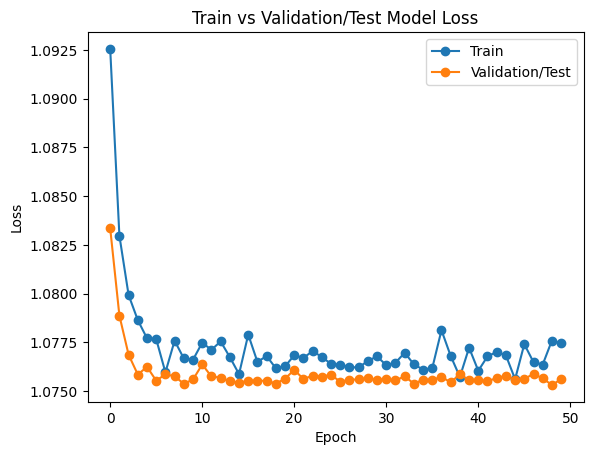

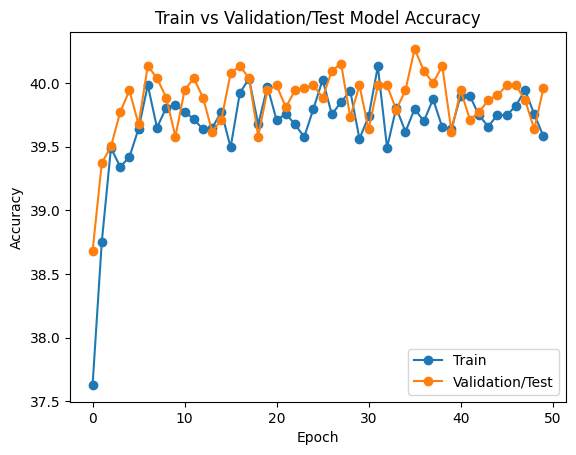


Calculating metrics...
Accuracy: 0.39961758255958557
Precision: [0.40717131 0.40742996 0.39005572]
Recall: [0.29334099 0.38360092 0.52178899]
F1 score: [0.34100767 0.39515653 0.44640667]
Support: [1742 1744 1744]
              precision    recall  f1-score   support

           0       0.41      0.29      0.34      1742
           1       0.41      0.38      0.40      1744
           2       0.39      0.52      0.45      1744

    accuracy                           0.40      5230
   macro avg       0.40      0.40      0.39      5230
weighted avg       0.40      0.40      0.39      5230

None


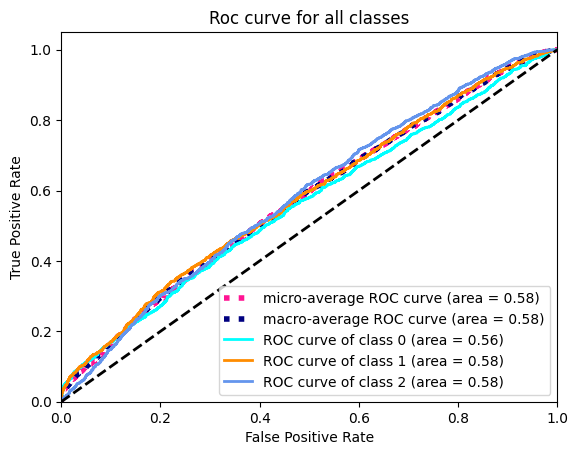

In [25]:
trained_model=data_train_model(train_data, val_data, stopwords_file, w2v_model, 'Text', 'Sentiment')

For submission

In [26]:
test=pd.read_csv('/kaggle/input/ys19-2023-assignment-2/test_set.csv',encoding='utf-8')
model=trained_model
checkpoint_path='current_checkpoint.pt'

In [27]:
def get_text(dataframe, Text, stopwords_file):

  # Get only the columns we are interested in
  dataset = dataframe[[Text]]

  # Apply the pre-processing function to the dataframe containing the text (feature column)
  dataset[Text] = dataset[Text].apply(preprocess_text, stopwords_file=stopwords_file)
  print('\nText done pre-processing!')

  # Get the text data
  X = dataset[Text]

  return X

def create_test_tensors(x):

  # Convert X datasets to tensors
  X_test_tensor = torch.tensor(x, dtype=torch.float)
  print('Tensors ready!')

  return X_test_tensor

def data_test_model(df_test, stopwords_file,  w2v_model, Text, model, checkpoint_path):

  # Prepare the training dataset
  print('------ Preparing the testing dataset... ------')

  X = get_text(df_test, Text, stopwords_file)

  w2vX_test, words_found, matrix_len = find_words_in_w2v(X,w2v_model)
  print('Percentage of words found in W2V: ', words_found/matrix_len)
  w2vX_test=scale_data(w2vX_test)
  # Create tensors for the training and testing/validation sets
  test_X_tensor = create_test_tensors(w2vX_test)
  test_data = torch.utils.data.TensorDataset(test_X_tensor)
  dataloader_test = torch.utils.data.DataLoader(test_data, batch_size = 128, shuffle = False)

  input_layer = test_X_tensor.shape[1]
  hidden_layer_1 = 43
  output_layer = 3
  num_epochs = 50
  
  optimizer = optim.RMSprop(model.parameters(), lr = 0.004)
  ckp_path = checkpoint_path
  model, optimizer,start_epoch, valid_loss_min = load_ckp(ckp_path, model, optimizer)
  
  print("model = ", model)
  print("optimizer = ", optimizer)
  print("start_epoch = ", start_epoch)
  print("valid_loss_min = ", valid_loss_min)
  print("valid_loss_min = {:.6f}".format(valid_loss_min))
  # Make predictions
 
  model.eval()  # Set the model to evaluation mode
  for tweet in test_X_tensor:
    with torch.no_grad():
      test_prediction = model(test_X_tensor)
      test_prediction = torch.argmax(test_prediction, dim=1)
      test_prediction=test_prediction.detach().numpy()
  return test_prediction

    

In [28]:
predicted_polarities=data_test_model(test,stopwords_file, w2v_model, 'Text',model,checkpoint_path)
print(predicted_polarities)
mapping = {0: 'NEUTRAL', 1: 'POSITIVE', 2: 'NEGATIVE'}
y_categorical = [mapping[value] for value in predicted_polarities]
# Print the result
#print(y_categorical)

------ Preparing the testing dataset... ------


/tmp/ipykernel_19/3449106275.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[Text] = dataset[Text].apply(preprocess_text, stopwords_file=stopwords_file)



Text done pre-processing!
Percentage of words found in W2V:  10.57650429799427
Tensors ready!
model =  Feed_forward_Neural_Net_Model(
  (layer_1): Linear(in_features=200, out_features=43, bias=True)
  (rrelu_1): RReLU(lower=0.125, upper=0.3333333333333333)
  (dropout): Dropout(p=0.4, inplace=False)
  (batch): BatchNorm1d(43, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_2): Linear(in_features=43, out_features=3, bias=True)
)
optimizer =  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    initial_lr: 0.005
    lr: 4.440892098500626e-18
    maximize: False
    momentum: 0
    weight_decay: 0
)
start_epoch =  51
valid_loss_min =  1.0756143767659256
valid_loss_min = 1.075614
[2 1 1 ... 2 2 2]


In [29]:
my_submission = pd.DataFrame({'Id': test.New_ID, 'Predicted': y_categorical})
my_submission.to_csv('submission-lt12200010.csv', index=False)

In [30]:
df=pd.read_csv('submission-lt12200010.csv')
# Check the distribution of classes
distribution = df['Predicted'].value_counts()/df.shape[0]
print('Distribution of data in classes:')
print(distribution)

Distribution of data in classes:
Predicted
NEGATIVE    0.452053
POSITIVE    0.306590
NEUTRAL     0.241356
Name: count, dtype: float64
